# Regression in PySpark's MLlib Project

Now it's time to put what you've learned to into action with a REAL project! 

You have been hired as a consultant to a cement production company who wants to be able to improve their customer experience around a number of areas like being able to provide recommendations to cusomters on optimal amounts of certian ingredients in the cement making process and perhaps even create an application where users can input their own values and received a predicted cement strength!

I have provided a list of question below to help guide you through this project but feel free to deviate and make this project your own! But first, a bit about this dataset.

### About this dataset 
This dataset contains 1030 instances of concrete samples, containing 9 attributes (8 continuous and 1 discreate), and 1 continuous quantitative output variable. There are no missing attribute values.

I've also provided the variable name, variable type, the measurement unit and a brief description of each variable in the dataset. The concrete compressive strength is the outcome variable for our analysis. The order of this listing corresponds to the order of numerals along the rows of the database.

Name -- Data Type -- Measurement -- Description

- Cement -- quantitative -- kg in a m3 mixture -- Input Variable 
- Blast Furnace Slag -- quantitative -- kg in a m3 mixture -- Input Variable 
- Fly Ash -- quantitative -- kg in a m3 mixture -- Input Variable 
- Water -- quantitative -- kg in a m3 mixture -- Input Variable 
- Superplasticizer -- quantitative -- kg in a m3 mixture -- Input Variable 
- Coarse Aggregate -- quantitative -- kg in a m3 mixture -- Input Variable 
- Fine Aggregate -- quantitative -- kg in a m3 mixture -- Input Variable 
- Age -- quantitative -- Day (1~365) -- Input Variable 
- Concrete compressive strength -- quantitative -- MPa -- Output Variable

**Source:** https://www.kaggle.com/maajdl/yeh-concret-data

**Dataset Name:** Concrete_Data.csv

In [10]:
import pyspark # only run after findspark.init()
from pyspark.sql import SparkSession
# May take awhile locally
spark = SparkSession.builder.appName("Regression").getOrCreate()

cores = spark._jsc.sc().getExecutorMemoryStatus().keySet().size()
print("You are working with", cores, "core(s)")
spark

You are working with 1 core(s)


In [11]:
from pyspark.ml.feature import VectorAssembler
from pyspark.sql.types import * 
from pyspark.sql.functions import *
from pyspark.ml.feature import StringIndexer

# To check for multicolinearity
from pyspark.ml.stat import Correlation

# For training and evaluation
from pyspark.ml.regression import *
from pyspark.ml.evaluation import *
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

In [12]:
path ="Datasets/"
df = spark.read.csv(path+'Concrete_Data.csv',inferSchema=True,header=True)

In [13]:
df.limit(5).toPandas()

,cement,slag,flyash,water,superplasticizer,coarseaggregate,fineaggregate,age,csMPa
0,540.0,0.0,0.0,162.0,2.5,1040.0,676.0,28,79.99
1,540.0,0.0,0.0,162.0,2.5,1055.0,676.0,28,61.89
2,332.5,142.5,0.0,228.0,0.0,932.0,594.0,270,40.27
3,332.5,142.5,0.0,228.0,0.0,932.0,594.0,365,41.05
4,198.6,132.4,0.0,192.0,0.0,978.4,825.5,360,44.30


## check null values precentage in all columns 

In [14]:
from pyspark.sql.functions import *

def null_value_calc(df):
    null_columns_counts = []
    numRows = df.count()
    for k in df.columns:
        nullRows = df.where(col(k).isNull()).count()
        
        if(nullRows > 0):
            temp = k,nullRows,(nullRows/numRows)*100
            null_columns_counts.append(temp)
        else:
            temp = k,nullRows,(nullRows/numRows)*100
            null_columns_counts.append(temp)
    return(null_columns_counts)

null_columns_calc_list = null_value_calc(df)
spark.createDataFrame(null_columns_calc_list, ['Column_Name', 'Null_Values_Count','Null_Value_Percent']).show()


+----------------+-----------------+------------------+
|     Column_Name|Null_Values_Count|Null_Value_Percent|
+----------------+-----------------+------------------+
|          cement|                0|               0.0|
|            slag|                0|               0.0|
|          flyash|                0|               0.0|
|           water|                0|               0.0|
|superplasticizer|                0|               0.0|
| coarseaggregate|                0|               0.0|
|   fineaggregate|                0|               0.0|
|             age|                0|               0.0|
|           csMPa|                0|               0.0|
+----------------+-----------------+------------------+



the data doesn't require cleaning  

## Data formatting  
treat outliers and skewness in each column and if there's any categorical data convert it to numeric values using string indexer  
create label column of the dependent variable and vectorize the selected features 

In [15]:
def MLRegressDFPrep(df,input_columns,dependent_var,treat_outliers=True):

    renamed = df.withColumnRenamed(dependent_var,'label')
    
    # Make sure dependent variable is numeric and change if it's not
    if str(renamed.schema['label'].dataType) != 'IntegerType':
        renamed = renamed.withColumn("label", renamed["label"].cast(FloatType()))
    
   # Convert all string type data in the input column list to numeric
    # Otherwise the Algorithm will not be able to process it
    numeric_inputs = []
    string_inputs = []
    for column in input_columns:
        if str(renamed.schema[column].dataType) == 'StringType':
            new_col_name = column+"_num"
            string_inputs.append(new_col_name)
        else:
            numeric_inputs.append(column)
            indexed = renamed
            
    if len(string_inputs) != 0: # If the datafraem contains string types
        for column in input_columns:
            if str(renamed.schema[column].dataType) == 'StringType':
                indexer = StringIndexer(inputCol=column, outputCol=column+"_num") 
                indexed = indexer.fit(renamed).transform(renamed)
    else:
        indexed = renamed
        
            
    if treat_outliers == True:
        print("We are correcting for non normality now!")
        # empty dictionary d
        d = {}
        # Create a dictionary of quantiles
        for col in numeric_inputs: 
            d[col] = indexed.approxQuantile(col,[0.01,0.99],0.25) #if you want to make it go faster increase the last number
        #Now fill in the values
        for col in numeric_inputs:
            skew = indexed.agg(skewness(indexed[col])).collect() #check for skewness
            skew = skew[0][0]
            # This function will floor, cap and then log+1 (just in case there are 0 values)
            if skew > 1:
                indexed = indexed.withColumn(col, \
                log(when(df[col] < d[col][0],d[col][0])\
                .when(indexed[col] > d[col][1], d[col][1])\
                .otherwise(indexed[col] ) +1).alias(col))
                print(col+" has been treated for positive (right) skewness. (skew =)",skew,")")
            elif skew < -1:
                indexed = indexed.withColumn(col, \
                exp(when(df[col] < d[col][0],d[col][0])\
                .when(indexed[col] > d[col][1], d[col][1])\
                .otherwise(indexed[col] )).alias(col))
                print(col+" has been treated for negative (left) skewness. (skew =",skew,")")
                
    # Vectorize your features
    features_list = numeric_inputs + string_inputs
    assembler = VectorAssembler(inputCols=features_list,outputCol='features')
    final_data = assembler.transform(indexed).select('features','label')
        
    return final_data

In [16]:
df.columns

['cement',
 'slag',
 'flyash',
 'water',
 'superplasticizer',
 'coarseaggregate',
 'fineaggregate',
 'age',
 'csMPa']

In [17]:
from pyspark.ml.feature import VectorAssembler
from pyspark.sql.types import * 
from pyspark.sql.functions import *
from pyspark.ml.feature import StringIndexer
from pyspark.ml.feature import MinMaxScaler

input_columns = df.columns[:-1]
dependent_var = df.columns[-1]

final_data = MLRegressDFPrep(df,input_columns,dependent_var)
final_data.show(5)

We are correcting for non normality now!
age has been treated for positive (right) skewness. (skew =) 3.2644145354168086 )
+--------------------+-----+
|            features|label|
+--------------------+-----+
|[540.0,0.0,0.0,16...|79.99|
|[540.0,0.0,0.0,16...|61.89|
|[332.5,142.5,0.0,...|40.27|
|[332.5,142.5,0.0,...|41.05|
|[198.6,132.4,0.0,...| 44.3|
+--------------------+-----+
only showing top 5 rows



## check Multicollinearity  

In [18]:
pearsonCorr = Correlation.corr(final_data, 'features', 'pearson').collect()[0][0]
array = pearsonCorr.toArray()

<AxesSubplot: >

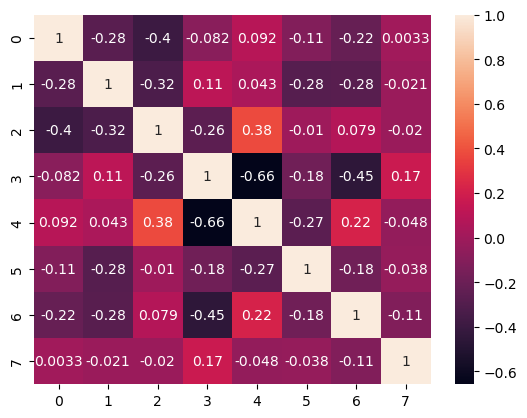

In [19]:
import seaborn as sns 
sns.heatmap(array, annot=True)

water and superplasticizer are negatively correlateed (strong negative correlation)(feature 3 & 4) value = -0.66  
water and age are negatively correlated value =-0.45 (feature 3 & 6)


#### dropping colinear feature 

In [20]:
df=df.drop('water')
input_columns = df.columns[:-1]
dependent_var = df.columns[-1]

final_data = MLRegressDFPrep(df,input_columns,dependent_var)
final_data.show(5)

We are correcting for non normality now!
age has been treated for positive (right) skewness. (skew =) 3.2644145354168086 )
+--------------------+-----+
|            features|label|
+--------------------+-----+
|[540.0,0.0,0.0,2....|79.99|
|[540.0,0.0,0.0,2....|61.89|
|[332.5,142.5,0.0,...|40.27|
|[332.5,142.5,0.0,...|41.05|
|[198.6,132.4,0.0,...| 44.3|
+--------------------+-----+
only showing top 5 rows



In [29]:
pearsonCorr = Correlation.corr(final_data, 'features', 'pearson').collect()[0][0]
array = pearsonCorr.toArray()

<AxesSubplot: >

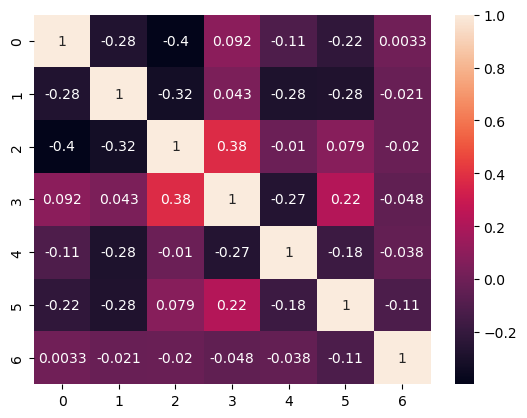

In [30]:
import seaborn as sns 
sns.heatmap(array, annot=True)

In [31]:
train,test = final_data.randomSplit([0.7,0.3])

## training the model 

In [32]:
from pyspark.ml.regression import *
from pyspark.ml.evaluation import *
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

In [33]:
def RegressTrainEval(regressor):

    def FindMtype(regressor):
        # Intstantiate Model
        M = regressor
        # Learn what it is
        Mtype = type(M).__name__
        
        return Mtype
    
    Mtype = FindMtype(regressor)
#     print('\033[1m' + Mtype + ':' + '\033[0m')


    if Mtype == "LinearRegression":
        
        #first without cross val
        fitModel = regressor.fit(train)

        # Load the Summary
        trainingSummary = fitModel.summary
        
        # Print the coefficients and intercept for linear regression
        print('\033[1m' + "Linear Regression Model Training Summary without cross validation:"+ '\033[0m')
        print(" ")
        print("Intercept: %s" % str(fitModel.intercept))
        print("")
        print("Coefficients: ")
        coeff_array = fitModel.coefficients.toArray()
        # Convert from numpy array to list
        coeff_list = []
        for x in coeff_array:
            coeff_list.append(float(x))
        result = spark.createDataFrame(zip(input_columns,coeff_list), schema=['feature','coeff'])
        print(result.orderBy(result["coeff"].desc()).show(truncate=False))



        # Summarize the model over the training set and print out some metrics
        print("numIterations: %d" % trainingSummary.totalIterations)
        print("objectiveHistory: (scaled loss + regularization) at each iteration \n %s" % str(trainingSummary.objectiveHistory))
        print("")
        
        # Print the Errors
        print("Training RMSE: %f" % trainingSummary.rootMeanSquaredError)
        print("Training r2: %f" % trainingSummary.r2)
        print("")
        

        # Now load the test results
        test_results = fitModel.evaluate(test)

        # And print them
        print("Test RMSE: {}".format(test_results.rootMeanSquaredError))
        print("Test r2: {}".format(test_results.r2))
        print("")
        
        #Now train with cross val
        paramGrid = (ParamGridBuilder() \
#              .addGrid(regressor.maxIter, [10, 15]) \
             .addGrid(regressor.regParam, [0.1, 0.01]) \
             .build())
        
        #Evaluator
        revaluator = RegressionEvaluator(metricName="rmse")
        
        #Cross Validator requires all of the following parameters:
        crossval = CrossValidator(estimator=regressor,
                                  estimatorParamMaps=paramGrid,
                                  evaluator=revaluator,
                                  numFolds=2) # 3 is best practice
        
        print('\033[1m' + "Linear Regression Model Summary WITH cross validation:"+ '\033[0m')
        print(" ")
        # Run cross validations
        fitModel = crossval.fit(train)
        
        #save model
        global LR_BestModel 
        LR_BestModel = fitModel.bestModel
        
        print("Coefficients: ")
        coeff_array = LR_BestModel.coefficients.toArray()
        # Convert from numpy array to list
        coeff_list = []
        for x in coeff_array:
            coeff_list.append(float(x))
        result = spark.createDataFrame(zip(input_columns,coeff_list), schema=['feature','coeff'])
        print(result.orderBy(result["coeff"].desc()).show(truncate=False))
        
        # Get Model Summary Statistics
        ModelSummary = fitModel.bestModel.summary
        
        print("Coefficient Standard Errors: ")
        coeff_ste = ModelSummary.coefficientStandardErrors
        result = spark.createDataFrame(zip(input_columns,coeff_ste), schema=['feature','coeff std error'])
        print(result.orderBy(result["coeff std error"].desc()).show(truncate=False))
        print(" ")
        print("P Values: ") 
        # Then zip with input_columns list and create a df
        pvalues = ModelSummary.pValues
        result = spark.createDataFrame(zip(input_columns,pvalues), schema=['feature','P-Value'])
        print(result.orderBy(result["P-Value"].desc()).show(truncate=False))
        print(" ")
        
        # Use test set here so we can measure the accuracy of our model on new data
        ModelPredictions = fitModel.transform(test)
        
        # cvModel uses the best model found from the Cross Validation
        # Evaluate best model
        test_results = revaluator.evaluate(ModelPredictions)
        print('RMSE:', test_results)
    
        # Set the column names to match the external results dataframe that we will join with later:
        columns = ['Regressor', 'Result']
        
        # Format results and return
        rmse_str = [str(test_results)] #make this a string and convert to a list
        Mtype = [Mtype] #make this a string
        result = spark.createDataFrame(zip(Mtype,rmse_str), schema=columns)
        result = result.withColumn('Result',result.Result.substr(0, 5))
        return result

    else:

        # Add parameters of your choice here:
        if Mtype in("RandomForestRegressor"):
            paramGrid = (ParamGridBuilder() \
#                            .addGrid(regressor.maxDepth, [2, 5, 10])
#                            .addGrid(regressor.maxBins, [5, 10, 20])
                           .addGrid(regressor.numTrees, [5, 20])
                         .build())

        # Add parameters of your choice here:
        if Mtype in("GBTRegressor"):
            paramGrid = (ParamGridBuilder() \
#                          .addGrid(regressor.maxDepth, [2, 5, 10, 20, 30]) \
                         .addGrid(regressor.maxBins, [10, 20]) \
                         .addGrid(regressor.maxIter, [10, 15])
                         .build())

        # Add parameters of your choice here:
        if Mtype in("DecisionTreeRegressor"):
            paramGrid = (ParamGridBuilder() \
#                          .addGrid(regressor.maxDepth, [2, 5, 10, 20, 30]) \
                         .addGrid(regressor.maxBins, [10, 20, 40]) \
                         .build())

        #Cross Validator requires all of the following parameters:
        crossval = CrossValidator(estimator=regressor,
                                  estimatorParamMaps=paramGrid,
                                  evaluator=RegressionEvaluator(metricName="rmse"),
                                  numFolds=2) # 3 is best practice
        # Fit Model: Run cross-validation, and choose the best set of parameters.
        fitModel = crossval.fit(train)
        
        # Get Best Model
        BestModel = fitModel.bestModel

        # FEATURE IMPORTANCES
        # Estimate of the importance of each feature.
        # Each feature’s importance is the average of its importance across all trees 
        # in the ensemble The importance vector is normalized to sum to 1. 
        print(" ")
        print('\033[1m' + Mtype," Feature Importances"+ '\033[0m')
        print("(Scores add up to 1)")
        print("Lowest score is the least important")
        print(" ")
        featureImportances = BestModel.featureImportances.toArray()
        # Convert from numpy array to list
        imp_scores = []
        for x in featureImportances:
            imp_scores.append(float(x))
        # Then zip with input_columns list and create a df
        result = spark.createDataFrame(zip(input_columns,imp_scores), schema=['feature','score'])
        print(result.orderBy(result["score"].desc()).show(truncate=False))
        
        #Create Global Variables for feature importances and models
        if Mtype in("DecisionTreeRegressor"):
            global DT_featureImportances
            DT_featureImportances = BestModel.featureImportances.toArray()
            global DT_BestModel 
            DT_BestModel = fitModel.bestModel
        if Mtype in("GBTRegressor"):
            global GBT_featureImportances
            GBT_featureImportances = BestModel.featureImportances.toArray()
            global GBT_BestModel 
            GBT_BestModel = fitModel.bestModel
        if Mtype in("RandomForestRegressor"):
            global RF_featureImportances
            RF_featureImportances = BestModel.featureImportances.toArray()
            global RF_BestModel 
            RF_BestModel = fitModel.bestModel
                    
        # Set the column names to match the external results dataframe that we will join with later:
        columns = ['Regressor', 'Result']
        
        # Make predictions.
        predictions = fitModel.transform(test)
        # Select (prediction, true label) and compute test error
        evaluator = RegressionEvaluator(metricName="rmse")
        rmse = evaluator.evaluate(predictions)
        rmse_str = [str(rmse)] #make this a string and convert to a list
        Mtype = [Mtype] #make this a string
        result = spark.createDataFrame(zip(Mtype,rmse_str), schema=columns)
        # Clean up the Result column and output
        result = result.withColumn('Result',result.Result.substr(0, 5))
        return result

In [34]:
regressors = [
                LinearRegression()
                ,DecisionTreeRegressor()
                ,RandomForestRegressor()
                ,GBTRegressor()
                ] 
    
#set up your results table
columns = ['Regressor', 'Result']
vals = [("Place Holder","N/A")]
results = spark.createDataFrame(vals, columns)

for regressor in regressors:
    new_result = RegressTrainEval(regressor)
    results = results.union(new_result)
results = results.where("Regressor!='Place Holder'")
results.show(100,False)

Linear Regression Model Training Summary without cross validation:
 
Intercept: -156.10649070101462

Coefficients: 
+----------------+-------------------+
|feature         |coeff              |
+----------------+-------------------+
|age             |9.497239521464273  |
|superplasticizer|0.2307057412070191 |
|cement          |0.15305016279407044|
|slag            |0.13728845324078653|
|flyash          |0.12294886604665406|
|fineaggregate   |0.0650023201559844 |
|coarseaggregate |0.05098091561860772|
+----------------+-------------------+

None
numIterations: 0
objectiveHistory: (scaled loss + regularization) at each iteration 
 [0.0]

Training RMSE: 7.453432
Training r2: 0.802022

Test RMSE: 6.735711635524768
Test r2: 0.8311648931674344

Linear Regression Model Summary WITH cross validation:
 
Coefficients: 
+----------------+-------------------+
|feature         |coeff              |
+----------------+-------------------+
|age             |9.484710340401378  |
|superplasticizer|0.237

the Gradient Boost regressor scores the lowest rmse 

In [36]:
test_sample = test.limit(10)
# predictions = GBT_BestModel.transform(test_sample) #testing the model on only 10 of the test dataset
predictions = GBT_BestModel.transform(test)
predictions = predictions.withColumn("difference",predictions.prediction-predictions.label) \
                         .withColumn("diff perct",((predictions.prediction-predictions.label)/predictions.label)*100)
print(predictions.show())
print(predictions.describe(['diff perct']).show())

+--------------------+-----+------------------+--------------------+--------------------+
|            features|label|        prediction|          difference|          diff perct|
+--------------------+-----+------------------+--------------------+--------------------+
|[102.0,153.0,0.0,...| 4.57| 8.424848405386618|  3.8548482337252405|   84.35116168330143|
|[102.0,153.0,0.0,...| 7.68| 12.23420011199393|   4.554200283655307|   59.29948418554191|
|[132.0,207.0,161....| 33.3| 35.16190953495078|  1.8619102978902333|   5.591322343989902|
|[133.0,210.0,0.0,...|31.03|32.736138192519334|  1.7061375058738264|   5.498348269802336|
|[135.0,105.0,193....|21.91|26.751868304239565|   4.841868456827456|  22.098897720436774|
|[135.7,203.5,0.0,...| 7.51| 9.992945952704527|  2.4829457238226915|   33.06185949600666|
|[136.0,162.0,126....|29.07|30.773198675370146|  1.7031989805459276|    5.85895768292414|
|[139.9,132.6,103....|36.44|26.406991871287225|  -10.03300675542176| -27.532950421320784|
|[141.3,21

## 1. Which features are the strongest predictors of cement strength?

Build your own ML model to figure this one out! This would be good information to give to our client so the sales reps can focus their efforts on certian ingredients to provide recommendations on. For example, if our clients had a customer that was struggling with their cement breaking, we could trouble shoot with them by starting with the factors that we know are important. 

In [38]:
GBT_featureImportances[1]

0.08954922645082435

In [117]:
import numpy as np
top_5_idx = np.argsort(GBT_featureImportances)[-5:][::-1].astype(int)
top_5_values = [float(GBT_featureImportances[i]) for i in top_5_idx]
input_columns = df.columns[:-1]
input_columns_top_5= [input_columns[i] for i in top_5_idx ]
input_columns_top_5

['age', 'cement', 'superplasticizer', 'slag', 'fineaggregate']

In [119]:
result = spark.createDataFrame(zip(input_columns_top_5,top_5_values), schema=['feature','score'])
result.show()

+----------------+-------------------+
|         feature|              score|
+----------------+-------------------+
|             age|0.31297806983174237|
|          cement|0.25026215301475313|
|superplasticizer|0.14264540021935418|
|            slag|0.08954922645082435|
|   fineaggregate|0.08290023920128223|
+----------------+-------------------+



##### it's shown that cement and age are the top 2 values 

## 2. For the following given inputs, what would be the estimated cement strength?

- Cement: 540
- Blast Furnace Slag: 0
- Fly Ash: 0
- Water: 162
- Superplasticizer: 2.5
- Coarse Aggregate: 1040
- Fine Aggregate: 676
- Age: 28

The correct answer is 79.99. Let's how close your prediction is!

In [79]:
test_entry=spark.createDataFrame([(540,0,0,2.5,1040,676,28)], schema=df.columns[:-1])
test_entry.show()

+------+----+------+----------------+---------------+-------------+---+
|cement|slag|flyash|superplasticizer|coarseaggregate|fineaggregate|age|
+------+----+------+----------------+---------------+-------------+---+
|   540|   0|     0|             2.5|           1040|          676| 28|
+------+----+------+----------------+---------------+-------------+---+



##### vectorize the test entry

In [81]:
assembler = VectorAssembler(inputCols=df.columns[:-1],outputCol='features')
final_entry = assembler.transform(test_entry).select('features')
final_entry.show()

+--------------------+
|            features|
+--------------------+
|[540.0,0.0,0.0,2....|
+--------------------+



In [83]:
label = 79.99
predictions = GBT_BestModel.transform(final_entry)
predictions = predictions.withColumn("difference",predictions.prediction-label) \
                         .withColumn("diff perct",((predictions.prediction-label)/label)*100)
print(predictions.show())
print(predictions.describe(['diff perct']).show())

+--------------------+-----------------+-------------------+-------------------+
|            features|       prediction|         difference|         diff perct|
+--------------------+-----------------+-------------------+-------------------+
|[540.0,0.0,0.0,2....|68.36601760035781|-11.623982399642188|-14.531794473861966|
+--------------------+-----------------+-------------------+-------------------+

None
+-------+-------------------+
|summary|         diff perct|
+-------+-------------------+
|  count|                  1|
|   mean|-14.531794473861966|
| stddev|               null|
|    min|-14.531794473861966|
|    max|-14.531794473861966|
+-------+-------------------+

None


## 3. Now see if you can ask users to input their own value for Age and return a predicted value for the cement stength. 

We did not cover this is in the lecture so you'll have to put your thinking cap on. Accepting user input in PySpark works just like it does in traditional Python.
<br>

val = input("Enter your value: ") 

In [90]:
val = int(input("Enter your value: "))

Enter your value:  28


In [91]:
test_entry=spark.createDataFrame([(540,0,0,2.5,1040,676,val)], schema=df.columns[:-1])
test_entry.show()

+------+----+------+----------------+---------------+-------------+---+
|cement|slag|flyash|superplasticizer|coarseaggregate|fineaggregate|age|
+------+----+------+----------------+---------------+-------------+---+
|   540|   0|     0|             2.5|           1040|          676| 28|
+------+----+------+----------------+---------------+-------------+---+



In [92]:
assembler = VectorAssembler(inputCols=df.columns[:-1],outputCol='features')
final_entry = assembler.transform(test_entry).select('features')
final_entry.show()


+--------------------+
|            features|
+--------------------+
|[540.0,0.0,0.0,2....|
+--------------------+



In [93]:
label = 79.99
predictions = GBT_BestModel.transform(final_entry)
predictions = predictions.withColumn("difference",predictions.prediction-label) \
                         .withColumn("diff perct",((predictions.prediction-label)/label)*100)
print(predictions.show())
print(predictions.describe(['diff perct']).show())

+--------------------+-----------------+-------------------+-------------------+
|            features|       prediction|         difference|         diff perct|
+--------------------+-----------------+-------------------+-------------------+
|[540.0,0.0,0.0,2....|68.36601760035781|-11.623982399642188|-14.531794473861966|
+--------------------+-----------------+-------------------+-------------------+

None
+-------+-------------------+
|summary|         diff perct|
+-------+-------------------+
|  count|                  1|
|   mean|-14.531794473861966|
| stddev|               null|
|    min|-14.531794473861966|
|    max|-14.531794473861966|
+-------+-------------------+

None


## 4. Make recommendations of optimal values for cement ingredients (our features)

See if you can find the optimal amount of cement to recommend holding the rest of the values from the previous question constant, assuming that the higher the cement strength value the better. 

first start off by getting max and min value for cement in the dataset then create array of random numbers ranging between theses values   
having an array of different cement values we enter it to the model and get the max value for strength

In [121]:
max_value = df.agg({"cement": "max"}).collect()[0][0]
max_value

540.0

In [122]:
min_value = df.agg({"cement": "min"}).collect()[0][0]
min_value

102.0

In [176]:
cement_range= np.arange(min_value,max_value,30).astype(int)
cement_range.tolist()

[102, 132, 162, 192, 222, 252, 282, 312, 342, 372, 402, 432, 462, 492, 522]

In [177]:
optimal_values=[]
for i in range(len(cement_range)):
    test_entry=spark.createDataFrame([(int(cement_range[i]),0,0,2.5,1040,676,28)], schema=df.columns[:-1])
    assembler = VectorAssembler(inputCols=df.columns[:-1],outputCol='features')
    final_entry = assembler.transform(test_entry).select('features')
    predictions = GBT_BestModel.transform(final_entry)
    optimal_values.append(float(predictions.collect()[0][1]))




In [178]:
optimal_values

[16.72229490174776,
 16.72229490174776,
 16.72229490174776,
 47.001339652245946,
 48.76330179134372,
 49.81828149911848,
 50.79344294600187,
 50.79344294600187,
 50.79344294600187,
 67.64092059681336,
 67.64092059681336,
 67.64092059681336,
 66.9470721839586,
 68.36601760035781,
 68.36601760035781]

In [179]:
max_index= np.argsort(optimal_values)[-1:][::-1].astype(int)
cement_range[max_index]

array([522])

### the value 522 is the optimum cement value for max strength